To do: 
For each author, show most discriminative features with bars

### Load Context

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

from kedro.framework.session import KedroSession

with KedroSession.create("biblical_scripts") as session:
    ctx = session.load_context()

params = ctx.params


/usr/local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/site-packages/statsmodels/iolib/foreign.py:651: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/pyth

2021-11-23 23:59:19,769 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


## Plotting functions

In [319]:
def remove_backslash(text):
    return text.split("/")[0]

def remove_teamim(my_string):
    return ''.join(['' if  (ord(c) <= 1456) and (ord(c) > 123) else c for c in my_string])

def replace_special(text):
    if text == "<Np>":
        return "(proper name)"
    elif text == "<Ng>":
        return "(gentilic name)"
    elif text == "<Ac>":
        return "(cardinal number)"
    elif text == "<Pp>":
        return "(personal proposition)"
    elif text == "<Nc>":
        return "(common noun)"
    elif text == "<Vq>":
        return "(verb)"
    return text  

def prepare_text(text):
    return remove_teamim(
                remove_backslash(
                replace_special(text)))

from bidi import algorithm as bidialg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_words_volcano(dfa):
    L = int(len(dfa) / 3)
    fig=figure(figsize=(4, L), dpi=80)
    dfa.loc[:, 'value'] = -np.log(dfa.pval) * dfa['affinity']

    dfb = dfa[::-1]

    ax1 = plt.axes()

    tab_blue='#288FB7'
    tab_gray='#7F7F7F'
    tab_brown="#8C564B"
    light_gray="gray"

    plt.barh(range(k), dfb['value'], color=light_gray,
             height=1, alpha=.5)

    for i, r in enumerate(dfb.iterrows()):
        #Create an axis text object
        sgn = 2*(r[1]['value'] > 0) - 1
        
        wl = len(r[1].term)
        x = r[1]['value'] / 2
        text = prepare_text(f'{r[1].term}')
        plt.text(x, #X location of text (with adjustment)
                i, #Y location
                s=bidialg.get_display(text), #Required label with formatting
                va='center', #Vertical alignment
                ha='center', #Horizontal alignment
                color='black', #Font colour and size
                #backgroundcolor='white',
                fontsize=12, name="Ariel") 
        plt.xlabel('log(p)')

    #ax1.get_yaxis().set_visible(True)
    plt.yticks([])
    plt.xticks([-100, -50, 0, 50, 100])
    return plt.gca()

# Features

In [320]:
from biblical_scripts.extras.Convert import Convert
from biblical_scripts.pipelines.sim.nodes import build_model

In [321]:
data = ctx.catalog.load("data_proc")
vocab = ctx.catalog.load("vocabulary")
data_raw = ctx.catalog.load('oshb_parsed')

2021-11-26 23:53:07,656 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2021-11-26 23:53:07,852 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...
2021-11-26 23:53:07,866 - kedro.io.data_catalog - INFO - Loading data from `oshb_parsed` (CSVDataSet)...


### Prepare data for each author

In [322]:
md = build_model(data[data.author.isin(params['known_authors'])], vocab, params['model'])
df = md[0].HCT_vs_many()

lo_auth = ["Dtr", "DtrH", "P"]
for auth  in lo_auth :
    df.loc[:,f'{auth}:freq'] =  df[f'{auth}:n'] / df[f'{auth}:T']

df.loc[:,"freq_common"] =  df['n'] / df['T']

dfm = df[df.iloc[:, # only use features selected at least once
                  df.columns.str.contains('affinity')].abs().any(axis=1)].reset_index()

cvr = Convert(data_raw)
dfm['term'] = dfm['feature'].apply(cvr._lem2term)


Affinity check: 1.0 (needs to be 1)


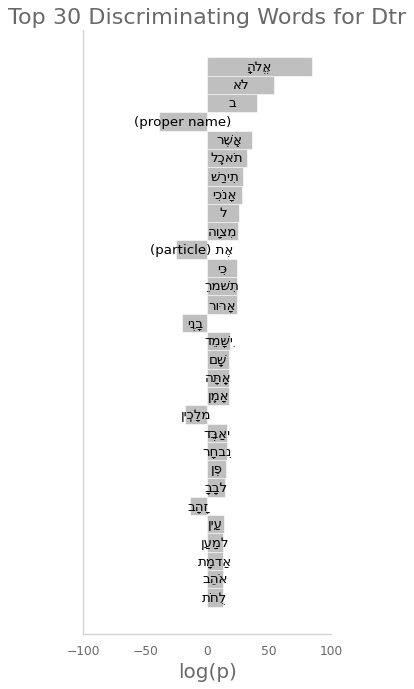

Affinity check: 1.0 (needs to be 1)


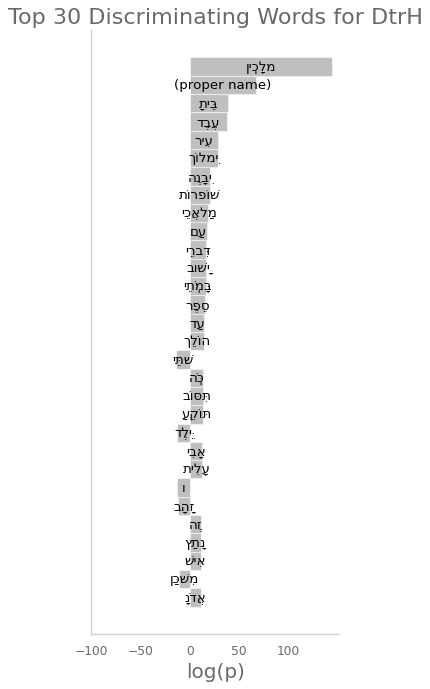

Affinity check: 1.0 (needs to be 1)


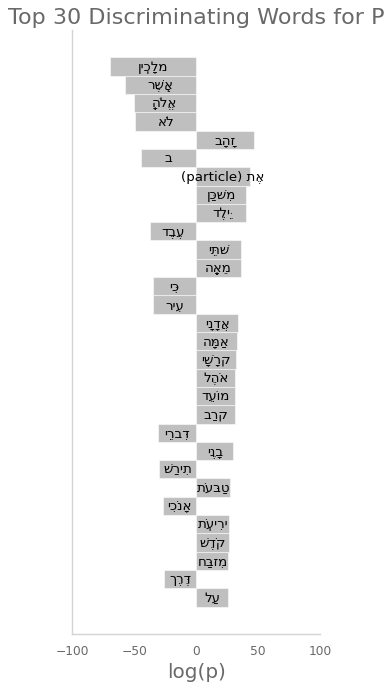

In [324]:
k = 30

for auth in lo_auth :
    dfa = dfm.reset_index()\
        .rename(columns = {f'{auth}:pval' : 'pval', f'{auth}:affinity' : 'affinity', f'{auth}:freq' : 'freq'})\
        .filter(['term', 'feature', 'freq', 'pval', 'affinity', 'freq_common'])        
    dfa = dfa.sort_values('pval', ascending=True)
    dfa = dfa[dfa['affinity'] != 0]
    dfa.to_csv(f"/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/08_reporting/features_{auth}.csv")
    chk = np.mean(2*(dfa['freq'] > dfa['freq_common'])-1 == dfa['affinity'])
    print(f"Affinity check: {chk} (needs to be 1)")
    
    
    plot_words_volcano(dfa[:k])
    plt.title(f"Top {k} Discriminating Words for {auth}")
    plt.savefig(f"data/08_reporting/Figs/feature_{auth}.png")
    plt.show()
    
    

#### Plot

In [213]:
import plotnine
plotnine.options.figure_size = (3, 5)
from plotnine import *
LIST_OF_COLORS = ['tab:red', 'tab:blue','tab:gray', "#00BA38", 
    'tab:olive', "#619CFF", 'tab:orange', "#F8766D",
    'tab:purple', 'tab:brown', 'tab:pink',
    'tab:green', 'tab:cyan', 'royalblue', 'darksaltgray', 'forestgreen',
    'cyan', 'navy'
    'magenta', '#595959', 'lightseagreen', 'orangered', 'crimson'
]



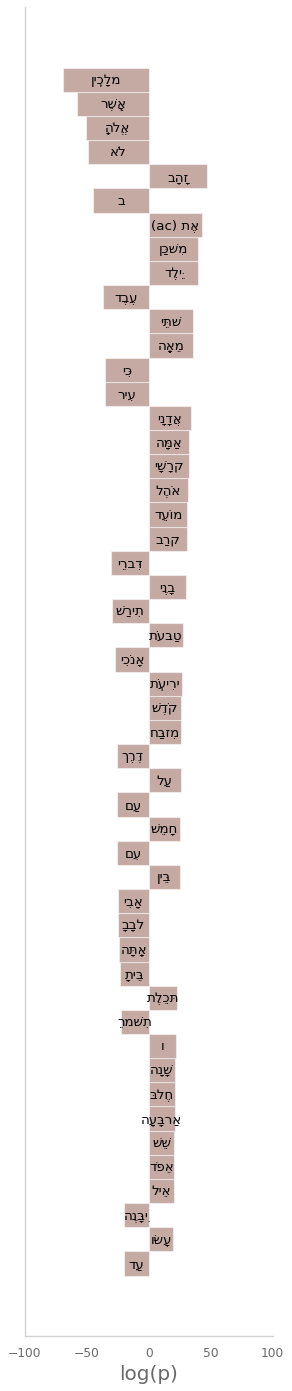

In [290]:
def plot_words_volcano(dfa):
    L = int(len(dfa) / 2.2)
    fig=figure(figsize=(4, L), dpi=80)
    dfa.loc[:, 'value'] = -np.log(dfa.pval) * dfa['affinity']

    dfb = dfa[::-1]

    ax1 = plt.axes()

    tab_blue='#288FB7'
    tab_gray='#7F7F7F'
    tab_brown="#8C564B"
    light_gray="gray"

    plt.barh(range(k), dfb['value'], color=tab_brown,
             height=1, alpha=.5)

    for i, r in enumerate(dfb.iterrows()):
        #Create an axis text object
        sgn = 2*(r[1]['value'] > 0) - 1
        
        wl = len(r[1].term)
        x = r[1]['value'] / 2
        text = remove_teamim_from_string(remove_backslash(f'{r[1].term}'))
        plt.text(x, #X location of text (with adjustment)
                i, #Y location
                s=bidialg.get_display(text), #Required label with formatting
                va='center', #Vertical alignment
                ha='center', #Horizontal alignment
                color='black', #Font colour and size
                #backgroundcolor=tab_gray,
                fontsize=12, name="Ariel") 
        plt.xlabel('log(p)')

    #ax1.get_yaxis().set_visible(True)
    plt.yticks([])
    plt.xticks([-100, -50, 0, 50, 100])
    return plt.gca()


k = 50
p = plot_words_volcano(dfa[:k])
plt.show()


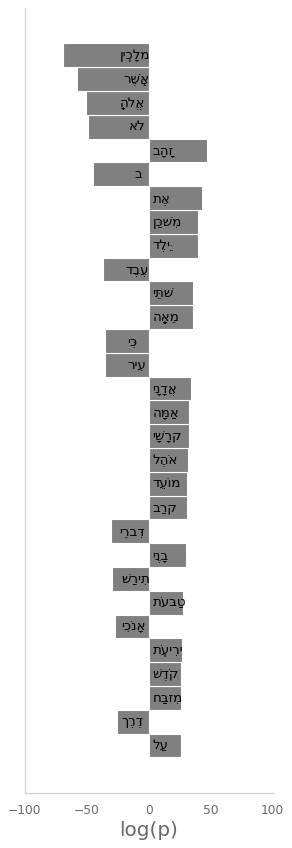

In [104]:
rcParams.keys()

NameError: name 'rcParams' is not defined

In [10]:
from bidi.algorithm import get_display

In [74]:
? "Hello".encode

Object ` "Hello".encode` not found.


In [84]:
dfs['value']

0     1.583875e-37
1     3.013310e-24
2     2.549655e-18
3    -1.147150e-17
4     1.591953e-16
5     9.586809e-15
6     2.489329e-13
7     4.137426e-13
8     7.412118e-12
9     1.098648e-11
10   -1.846787e-11
11    2.352119e-11
12    3.997105e-11
13    4.569030e-11
14   -2.056796e-09
15    1.316841e-08
16    1.726168e-08
17    1.726168e-08
18    2.126938e-08
19   -2.413427e-08
20    1.011609e-07
21    1.047148e-07
22    2.180160e-07
23    3.729539e-07
24   -7.529127e-07
25    1.532675e-06
26    1.924195e-06
27    2.079682e-06
28    3.525172e-06
29    3.913052e-06
30   -4.334328e-06
31    4.465602e-06
32    4.518714e-06
33    4.718157e-06
34    5.302598e-06
35    7.100972e-06
36    1.027217e-05
37    1.242990e-05
38    1.401353e-05
39    1.626821e-05
40    1.675272e-05
41   -1.839597e-05
42   -1.922984e-05
43    2.214414e-05
44   -2.980960e-05
45    3.357005e-05
46    3.357005e-05
47    3.801752e-05
48   -4.110162e-05
49   -4.884750e-05
50   -6.971160e-05
51   -9.932301e-05
52   -1.0721